In [9]:
import os
from pathlib import Path
import laspy
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
import re
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import seaborn as sns
from datetime import datetime, timedelta
from numpy.polynomial.polynomial import Polynomial
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import scipy.io as sio
from scipy.stats import mode
from matplotlib.patches import Patch


In [2]:
cropped_grid = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cropped_clusters.npz")['data']
cropped_clusters = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cropped_clusters.npz")['data']

full_grid = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/grid.npz")['data']
grid_files = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/grid_files.npz")['data']

acc_cropped_grid = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/acc_cropped_grid.npz")['data']
acc_cropped_clusters = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/acc_cropped_clusters.npz")['data']

acc_grid_files = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/acc_grid_files.npz")['data']
acc_cluster_files = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/acc_cluster_files.npz")['data']

In [ ]:
# def net_erosion_curve(grid_3d, grid_files, acc_grid_3d, acc_grid_files, plotAdam=False, res=0.01):
#     """
#     Plot the total volume for erosion, accretion, and net change (erosion + accretion) at each time step.
    
#     For each time step:
#       - Erosion volume is computed and forced to be negative.
#       - Accretion volume is computed and forced to be positive.
#       - Net change is computed as the sum (erosion + accretion).
      
#     The curves are plotted (without markers) with the x-axis showing time in days since the first date.
#     Vertical ticks mark January 1st for each year, and vertical dashed lines are drawn at these ticks
#     (with no labels). Winter seasons (Nov–Feb) are highlighted as shaded regions.
    
#     Parameters:
#         grid_3d (numpy.ndarray): 3D erosion grid data of shape (n_time, alongshore_length, depth).
#         grid_files (list of str): List of filenames for the erosion grid data.
#         acc_grid_3d (numpy.ndarray): 3D accretion grid data of shape (n_time, alongshore_length, depth).
#         acc_grid_files (list of str): List of filenames for the accretion grid data.
#         plotAdam (bool): If True, plot additional data from Adam's dataset (erosion only).
#         res (float): Resolution factor to multiply the grid data (e.g., cell volume multiplier).
#     """
#     # Regular expression to extract dates (assuming filenames contain an 8-digit date, e.g., YYYYMMDD)
#     date_pattern = re.compile(r"(\d{8})")
    
#     # Extract dates from erosion files.
#     erosion_dates = []
#     for file in grid_files:
#         match = date_pattern.findall(file)
#         if match and len(match) >= 4:
#             # Use the fourth occurrence of an 8-digit string as the date.
#             date_str = match[3]
#             erosion_dates.append(datetime.strptime(date_str, "%Y%m%d"))
#         else:
#             erosion_dates.append(None)
    
#     # Extract dates from accretion files.
#     acc_dates = []
#     for file in acc_grid_files:
#         match = date_pattern.findall(file)
#         if match and len(match) >= 4:
#             date_str = match[3]
#             acc_dates.append(datetime.strptime(date_str, "%Y%m%d"))
#         else:
#             acc_dates.append(None)
    
#     # Compute total volumes per time step.
#     # Erosion volumes: force to be negative.
#     erosion_volumes = -np.abs(np.nansum(grid_3d * res, axis=(1, 2)))
#     # Accretion volumes: force to be positive.
#     acc_volumes = np.abs(np.nansum(acc_grid_3d * res, axis=(1, 2)))
    
#     # Build dictionaries mapping date to volume for each dataset.
#     erosion_dict = {date: vol for date, vol in zip(erosion_dates, erosion_volumes) if date is not None}
#     acc_dict     = {date: vol for date, vol in zip(acc_dates, acc_volumes) if date is not None}
    
#     # Get the union of all valid dates and sort them.
#     all_dates = sorted(set(erosion_dict.keys()).union(acc_dict.keys()))
#     if not all_dates:
#         raise ValueError("No valid dates were extracted from the provided file names.")
    
#     # Build time series arrays for erosion and accretion (using 0 if missing for a time step).
#     erosion_series   = [erosion_dict.get(d, 0) for d in all_dates]
#     accretion_series = [acc_dict.get(d, 0) for d in all_dates]
    
#     # Compute net change as the sum of erosion and accretion.
#     net_series = np.array(erosion_series) + np.array(accretion_series)
    
#     # Create a time array (days since the first date).
#     first_date = all_dates[0]
#     time_array = np.array([(d - first_date).days for d in all_dates])
    
#     # Plot the total volumes for each time step.
#     plt.figure(figsize=(12, 3))
#     plt.plot(time_array, erosion_series, color='darkred', label='Erosion')
#     plt.plot(time_array, accretion_series, color='C0', label='Deposition')
#     plt.plot(time_array, net_series, color='black', label='Net Change')
#     plt.xlabel('Time', fontsize=15, fontweight='bold')
#     plt.ylabel('Observed\nChanges (m³)', fontsize=15, fontweight='bold')
#     plt.grid(True)
    
#     # Set x-ticks at January 1st for each year without any labels.
#     january_1st_dates = [datetime(year, 1, 1) for year in range(first_date.year, all_dates[-1].year + 1)]
#     january_1st_time_array = [(jan1 - first_date).days for jan1 in january_1st_dates]
#     plt.xticks(ticks=january_1st_time_array, labels=["" for _ in january_1st_time_array])
    
#     # Add vertical dashed lines at each January 1st tick.
#     for tick in january_1st_time_array:
#         plt.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5)
    
#     # Highlight winter season (November to February) with shaded vertical boxes.
#     last_date = all_dates[-1]
#     for year in range(first_date.year, last_date.year + 1):
#         winter_start = datetime(year, 11, 1)
#         winter_end   = datetime(year + 1, 2, 28)
#         if winter_start <= last_date and winter_end >= first_date:
#             start_time = (max(winter_start, first_date) - first_date).days
#             end_time   = (min(winter_end, last_date) - first_date).days
#             plt.axvspan(start_time, end_time, color='grey', alpha=0.4)
    
#     # Append winter patch to legend.
#     handles, labels = plt.gca().get_legend_handles_labels()
#     winter_patch = Patch(facecolor='grey', edgecolor='none', alpha=0.4, label='Winter (Nov-Feb)')
#     handles.append(winter_patch)
#     labels.append('Winter (Nov-Feb)')
#     plt.legend(handles=handles, labels=labels, loc='upper left')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Optionally plot Adam's data (unchanged, but without markers).
#     if plotAdam:
#         data2021 = pd.read_excel('/Users/cjmack/Documents/Papers/Cliffs/Scratch/1-s2.0-S0169555X20305183-mmc1.xlsx')
#         year  = data2021.iloc[1:, 1]
#         month = data2021.iloc[1:, 2]
#         day   = data2021.iloc[1:, 3]
#         date = pd.to_datetime(year.astype(str) + month.astype(str).str.zfill(2) + day.astype(str).str.zfill(2),
#                               format='%Y%m%d')
#         data2021['date'] = date
#         adam_time_array = np.array([(d - first_date).days for d in data2021['date']])
#         cumulative_adam = np.cumsum(np.abs(data2021['Negative Change (m^3)'].iloc[1:]))
#         plt.figure(figsize=(12, 3))
#         plt.plot(adam_time_array[1:], cumulative_adam, color='black', label="Young 2021")
#         plt.legend()
#         plt.show()


def net_erosion_curve(grid_3d, grid_files, acc_grid_3d, acc_grid_files, res=0.01):
    """
    Plot the total volume for erosion, accretion, and net change (erosion + accretion) at each time step,
    aggregating the surveys into evenly spaced weekly bins.

    For each survey:
      - The survey date is extracted from the filename (using the 4th occurrence of an 8-digit string).
      - Erosion volumes are computed (forced to be negative) and accretion volumes are computed (forced to be positive).
      - These volumes are summed into weekly bins on a timeline anchored at January 1, 2017.
    
    The x-axis represents time (in days since January 1, 2017) with vertical ticks at each January 1 and
    winter seasons (November–February) highlighted.

    Parameters:
        grid_3d (numpy.ndarray): 3D erosion grid data of shape (n_time, alongshore_length, depth).
        grid_files (list of str): List of filenames for the erosion grid data.
        acc_grid_3d (numpy.ndarray): 3D accretion grid data of shape (n_time, alongshore_length, depth).
        acc_grid_files (list of str): List of filenames for the accretion grid data.
        plotAdam (bool): If True, plot additional data from Adam's dataset (erosion only).
        res (float): Resolution factor to multiply the grid data.
    """


    # Regular expression to extract an 8-digit date from a filename.
    # (This code assumes the desired date is the fourth occurrence.)
    date_pattern = re.compile(r"(\d{8})")
    
    # Helper function: extract date from a file name using the 4th occurrence.
    def extract_date(fname):
        matches = date_pattern.findall(fname)
        if matches and len(matches) >= 4:
            try:
                return datetime.strptime(matches[3], "%Y%m%d")
            except Exception:
                return None
        return None

    # Extract dates for erosion and accretion surveys.
    erosion_dates = [extract_date(f) for f in grid_files]
    acc_dates     = [extract_date(f) for f in acc_grid_files]
    
    # Compute volumes for each survey.
    # Erosion volumes: forced negative.
    erosion_volumes = -np.abs(np.nansum(grid_3d * res, axis=(1, 2)))
    # Accretion volumes: forced positive.
    acc_volumes = np.abs(np.nansum(acc_grid_3d * res, axis=(1, 2)))
    
    # Combine all valid dates to determine the overall time span.
    all_dates = [d for d in erosion_dates + acc_dates if d is not None]
    if not all_dates:
        raise ValueError("No valid dates were extracted from the provided file names.")
    
    # Use January 1, 2017 as the anchor for the evenly spaced timeline.
    anchor_date = datetime(2017, 1, 1)
    start_date = min(all_dates)
    end_date = max(all_dates)
    
    # Create a weekly timeline (using Mondays) from the anchor date to a little past the last survey.
    weekly_dates = pd.date_range(start=anchor_date, end=end_date + timedelta(weeks=10), freq='W-MON')
    
    # Define bin edges (using ordinal values) and determine a "padding" offset.
    bin_edges = [d.toordinal() for d in weekly_dates] + [weekly_dates[-1].toordinal() + 7]
    padding_weeks = (start_date - anchor_date).days // 7  # Offset for surveys that occur after the anchor
    
    # Initialize weekly arrays for erosion and accretion.
    n_weeks = len(weekly_dates)
    weekly_erosion = np.zeros(n_weeks)
    weekly_accretion = np.zeros(n_weeks)
    
    # Function to assign a date to a week index.
    def assign_week(d):
        # Get the week bin label for the given date (using its ordinal)
        bin_label = pd.cut([d.toordinal()], bins=bin_edges, labels=range(n_weeks))[0]
        if pd.isna(bin_label):
            return None
        return int(bin_label) + padding_weeks

    # Aggregate erosion volumes into weekly bins.
    for vol, d in zip(erosion_volumes, erosion_dates):
        if d is None:
            continue
        week_idx = assign_week(d)
        if week_idx is not None and week_idx < n_weeks:
            weekly_erosion[week_idx] += vol

    # Aggregate accretion volumes into weekly bins.
    for vol, d in zip(acc_volumes, acc_dates):
        if d is None:
            continue
        week_idx = assign_week(d)
        if week_idx is not None and week_idx < n_weeks:
            weekly_accretion[week_idx] += vol

    # Compute net change.
    weekly_net = weekly_erosion + weekly_accretion

    # Create a time vector in days since the anchor.
    time_vector = np.array([(d - anchor_date).days for d in weekly_dates])
    
    # Plot the weekly time series.
    plt.figure(figsize=(12, 3))
    plt.plot(time_vector, weekly_erosion, color='darkred', label='Erosion')
    plt.plot(time_vector, weekly_accretion, color='C0', label='Deposition')
    plt.plot(time_vector, weekly_net, color='black', label='Net Change')
    plt.xlabel('Time (days since Jan 1, 2017)', fontsize=15, fontweight='bold')
    plt.ylabel('Observed Changes (m³)', fontsize=15, fontweight='bold')
    plt.grid(True)
    
    # Determine January 1st of each year between anchor and end.
    years = range(anchor_date.year, weekly_dates[-1].year + 1)
    jan1_dates = [datetime(year, 1, 1) for year in years]
    jan1_offsets = [(d - anchor_date).days for d in jan1_dates]
    # Set x-ticks (using these offsets) without labels.
    plt.xticks(jan1_offsets, [""] * len(jan1_offsets))
    # Add vertical dashed lines at each January 1st.
    for offset in jan1_offsets:
        plt.axvline(x=offset, color='gray', linestyle='--', linewidth=0.5)
    
    # Shade winter seasons (Nov 1 to Feb 28) for each winter period.
    for year in years:
        winter_start = datetime(year, 11, 1)
        winter_end = datetime(year + 1, 2, 28)
        # Only shade if the winter period overlaps our timeline.
        if winter_start <= end_date and winter_end >= anchor_date:
            start_offset = (max(winter_start, anchor_date) - anchor_date).days
            end_offset = (min(winter_end, weekly_dates[-1].to_pydatetime()) - anchor_date).days
            plt.axvspan(start_offset, end_offset, color='grey', alpha=0.4)
    
    # Append winter patch to the legend.
    winter_patch = Patch(facecolor='grey', edgecolor='none', alpha=0.4, label='Winter (Nov-Feb)')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(winter_patch)
    labels.append('Winter (Nov-Feb)')
    plt.legend(handles=handles, labels=labels, loc='upper left')
    
    plt.tight_layout()
    plt.show()



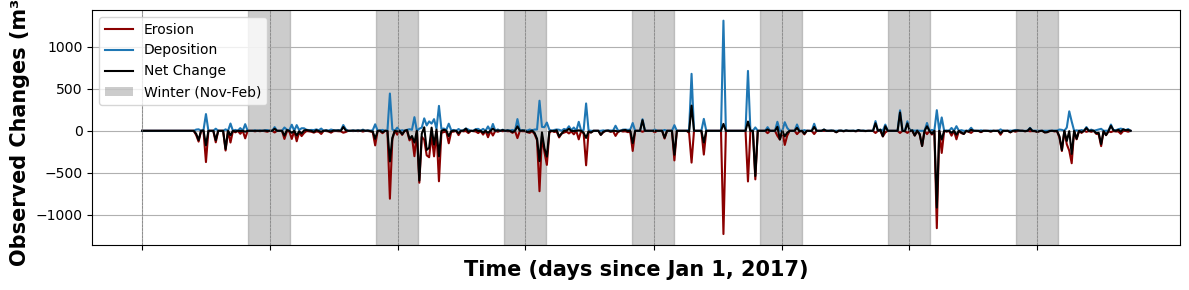

In [ ]:
net_erosion_curve(cropped_grid, grid_files, acc_cropped_grid, acc_grid_files, res=0.01)

In [67]:
def plot_heatmap_grid_1m(grid_10cm, file_list, vmax, res=0.01):
    """
    Creates a heatmap of erosion over time by aggregating 10x10cm resolution data to 1-meter resolution.
    Each cell is multiplied by the resolution before summing alongshore bins (10 points per bin) and depth bins.
    
    The function aggregates the surveys into a regularly spaced weekly timeline (starting from January 1st, 2017).
    If multiple surveys occur in the same week, their erosion volumes are summed.
    
    Returns:
        weekly_grid (numpy.ndarray): 2D array of shape (number_of_weeks, alongshore_bins) containing the aggregated weekly erosion data.
    """
    # (Ensure these imports are available in your script)
    import re, os
    from datetime import datetime, timedelta
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import seaborn as sns

    # Extract dimensions of the input grid
    time_steps, alongshore_length, depth_bins = grid_10cm.shape

    # Step 1: Process file dates and create weekly bins
    date_pattern = re.compile(r"(\d{8})")  # Match date (YYYYMMDD) in filenames
    date_labels = [datetime.strptime(date_pattern.search(os.path.basename(file)).group(1), "%Y%m%d")
                   for file in file_list]

    # Define January 1st, 2017 and calculate padding weeks
    january_1st_2017 = datetime(2017, 1, 1)
    start_date = min(date_labels)
    padding_weeks = (start_date - january_1st_2017).days // 7  # Number of weeks to pad

    # Extend the weekly dates to add extra buffer for any index overflow
    end_date = max(date_labels)
    weekly_dates = pd.date_range(start=january_1st_2017, end=end_date + timedelta(weeks=10), freq='W-MON')

    # Create week bins using ordinal values for comparison
    bin_edges = [week.toordinal() for week in weekly_dates] + [weekly_dates[-1].toordinal() + 7]
    week_bins = pd.cut([date.toordinal() for date in date_labels],
                       bins=bin_edges,
                       labels=range(len(weekly_dates)))

    # Step 2: Reduce resolution from 10cm to 1m by summing over groups of 10 alongshore points and depth bins.
    factor = 10
    alongshore_trimmed = alongshore_length - (alongshore_length % factor)  # Ensure divisibility by 10
    grid_10cm_trimmed = grid_10cm[:, :alongshore_trimmed, :] * res  # Multiply each cell by the resolution

    # Reduce alongshore dimension and sum over depth bins
    reduced_grid_10cm = np.nansum(grid_10cm_trimmed.reshape(time_steps, -1, factor, depth_bins), axis=2)
    grid_one_meter = np.nansum(reduced_grid_10cm, axis=2)  # Shape: (time_steps, alongshore_bins)

    # Step 3: Aggregate surveys into weekly bins.
    # Initialize the weekly grid with NaNs
    weekly_grid = np.full((len(weekly_dates), grid_one_meter.shape[1]), np.nan)
    
    # # Optional: print duplicate survey dates in 2018 and 2019 for debugging
    # duplicates = [date for date in date_labels if date.year in [2018, 2019]]
    # print("Duplicate survey dates in 2018 and 2019:", sorted(duplicates))

    # # Optional: print week bin assignments for 2018 and 2019 for debugging
    # date_week_assignments = {date: week for date, week in zip(date_labels, week_bins)}
    # print("Week bin assignments for 2018 and 2019:")
    # for date, week in date_week_assignments.items():
    #     if date.year in [2018, 2019]:
    #         print(f"{date}: Week bin {week}")

    # Loop over each survey and aggregate its data into the appropriate weekly bin
    for survey_idx, week_idx in enumerate(week_bins):
        if pd.notna(week_idx):
            week_index = int(week_idx) + padding_weeks
            if week_index < len(weekly_grid):  # Ensure index is in bounds
                if np.isnan(weekly_grid[week_index]).all():
                    weekly_grid[week_index] = grid_one_meter[survey_idx]
                else:
                    weekly_grid[week_index] += grid_one_meter[survey_idx]

    # Step 4: Create a custom colormap where the lowest values are white.
    reds_colormap = plt.cm.Reds
    colors = reds_colormap(np.linspace(0, 1, 256))
    colors[0] = [1, 1, 1, 1]  # Set the lowest value to white
    custom_colormap = mcolors.ListedColormap(colors)

    # Determine year labels at the first week of each year for the x-axis
    year_labels = [date.year for date in weekly_dates]
    unique_years = sorted(set(year_labels))
    first_week_of_year = [year_labels.index(year) for year in unique_years]

    # Step 5: Plot the heatmap
    plt.figure(figsize=(12, 6))
    # Transpose so that x-axis corresponds to time (weeks) and y-axis corresponds to alongshore location
    ax = sns.heatmap(weekly_grid.T, cmap=custom_colormap,
                     cbar_kws={'label': 'Observed Erosion (m³/m alongshore)', 'pad': 0.05},
                     mask=np.isnan(weekly_grid.T), vmin=0, vmax=vmax)

    # Customize the colorbar ticks
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 0.5, 1, 1.5, 2])
    colorbar.set_ticklabels(['0', '0.5', '1', '1.5', '2'])
    colorbar.ax.set_ylabel('Observed Erosion (m³/m alongshore)', fontweight='bold', fontsize=12)

    # Set x-axis ticks to show year labels at the start of each year
    plt.xticks(first_week_of_year, unique_years, rotation=0, ha="center", fontsize=14, fontweight='bold')

    # Set y-axis ticks for alongshore distance (adjust positions as needed)
    alongshore_labels = [0, 500, 1000, 1500, 2000, 2250]
    plt.yticks(alongshore_labels, alongshore_labels)

    # Label axes
    # plt.xlabel("Week", fontdict={'fontsize': 14, 'fontweight': 'bold'})
    plt.ylabel('Alongshore Location (m)', fontdict={'fontsize': 14, 'fontweight': 'bold'})
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    return weekly_grid


def plot_fraction_alongshore(one_meter):
    """
    Given the aggregated weekly grid (one_meter) of observed erosion 
    (with shape: [number_of_weeks, alongshore_bins]), this function computes 
    the percentage of total erosion (cliff activity) that occurs in each alongshore bin 
    (by summing over time) and produces a vertical profile plot.
    
    The horizontal axis shows the percentage of cliff activity, and the vertical axis 
    shows alongshore location (in meters), with 0 at the bottom.
    
    Parameters:
        one_meter (numpy.ndarray): 2D array of shape (weeks, alongshore_bins)
                                   containing the aggregated weekly erosion data.
    """
    # Sum over all weeks to get the total erosion per alongshore bin.
    alongshore_totals = np.nansum(one_meter, axis=0)
    
    # Compute the overall total erosion.
    total_erosion = np.nansum(alongshore_totals)
    
    # Compute the percentage for each alongshore bin.
    fraction_percent = (alongshore_totals / total_erosion) * 100
    
    # Create an array for alongshore distance (in meters).
    num_bins = one_meter.shape[1]
    alongshore_distance = np.arange(num_bins)
    
    # Create a skinnier figure (narrower width).
    plt.figure(figsize=(4, 10))
    plt.plot(fraction_percent, alongshore_distance, linewidth=2)
    
    # Set axis labels and title.
    plt.xlabel("Percentage of \nCliff Activity (%)", fontsize=16, fontweight='bold')
    plt.ylabel("Alongshore Location (m)", fontsize=16, fontweight='bold')
    # plt.title("Fraction of Cliff Activity per Alongshore Bin", fontsize=16, fontweight='bold')
    
    # Add grid lines and set y-limits.
    plt.grid(True)
    plt.ylim(0, num_bins - 1)
    plt.yticks([0, 500, 1000, 1500, 2000, 2250])
    plt.xticks([0, .25, .5, .75])
    
    # Move the y-axis label and ticks to the right.
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    plt.tight_layout()
    plt.show()


def cum_erosion_curve(grid_3d, grid_files, plotAdam=False, res=0.1):

    """
    Plot the cumulative erosion curve for the given grid data.
    The cumulative erosion is calculated by summing the grid data over all alongshore locations.
    
    Parameters:
    grid_3d (numpy.ndarray): 3D grid data of shape (time_steps, alongshore_length, depth).
    grid_files (list of filenames): List of filenames for the grid data.
    plotAdam (bool): If True, plot Adam's dataset on the same plot, also as cumulative erosion.
    """
    # Extract dates from grid_files using regular expression (assuming format YYYYMMDD)
    date_pattern = re.compile(r"(\d{8})")
    dates = []
    
    for file in grid_files:
        match = date_pattern.findall(file)
        if match:
            date_str = match[3]
            dates.append(datetime.strptime(date_str, "%Y%m%d"))

    # Create an evenly spaced time array between the first and last date
    first_date = min(dates)
    last_date = max(dates)
    time_array = np.array([(date - first_date).days for date in dates])  # Relative time in days from the first date

    # Sum the grid along the alongshore and depth axes
    erosion_per_time_step = np.nansum(grid_3d * res, axis=(1, 2))  # Sum over alongshore and depth axes

    # Calculate cumulative erosion
    cumulative_erosion = np.cumsum(erosion_per_time_step)

    # Plot cumulative erosion over time
    plt.figure(figsize=(12, 3))
    plt.plot(time_array, cumulative_erosion, marker='D', label='Cumulative Erosion')

    # Formatting plot
    plt.xlabel('Time', fontsize=15, fontweight='bold')
    plt.ylabel('Cumulative\n Erosion (m³)', fontsize=15, fontweight='bold')
    plt.grid(True)

    # Highlight winter season (Nov to Feb) with vertical boxes
    for year in range(first_date.year, last_date.year + 1):
        winter_start = datetime(year, 11, 1)
        winter_end = datetime(year + 1, 2, 28)  # Last day of February

        # Ensure dates are within the range of the dataset
        if winter_start <= last_date and winter_end >= first_date:
            start_time = (max(winter_start, first_date) - first_date).days
            end_time = (min(winter_end, last_date) - first_date).days
            plt.axvspan(start_time, end_time, color='grey', alpha=0.4)

    # Generate January 1st of each year between the first and last date
    min_year = first_date.year
    max_year = last_date.year
    january_1st_dates = [datetime(year, 1, 1) for year in range(min_year, max_year + 1)]

    # Convert January 1st dates to the same relative time format
    january_1st_time_array = [(jan1 - first_date).days for jan1 in january_1st_dates]

    # Plot Adam's data if plotAdam is True
    if plotAdam:
        data2021 = pd.read_excel('/Users/cjmack/Documents/Papers/Cliffs/Scratch/1-s2.0-S0169555X20305183-mmc1.xlsx')
        year = data2021.iloc[1:, 1]
        month = data2021.iloc[1:, 2]
        day = data2021.iloc[1:, 3]  
        
        # Combine them all as one date
        date = pd.to_datetime(year.astype(str) + month.astype(str).str.zfill(2) + day.astype(str).str.zfill(2), format='%Y%m%d')
        data2021['date'] = date

        # Convert Adam's dates to relative time (days since the first_date)
        adam_time_array = np.array([(d - first_date).days for d in data2021['date']])

        # Compute cumulative sum for Adam's data (Negative Change in m³)
        cumulative_adam = np.cumsum(np.abs(data2021['Negative Change (m^3)'].iloc[1:]))

        # Plot Adam's cumulative data
        plt.plot(adam_time_array[1:], cumulative_adam, marker='D', color='black', label="Young 2021")

    # Set X-ticks on January 1st but no labels
    plt.xticks(ticks=january_1st_time_array, labels=[], rotation=45)

    # Add legend for winter season using a patch
    winter_patch = Patch(facecolor='grey', edgecolor='none', alpha=0.4, label='Winter (Nov-Feb)')
    plt.legend(handles=[winter_patch], loc='upper left')

    plt.tight_layout()
    plt.show()


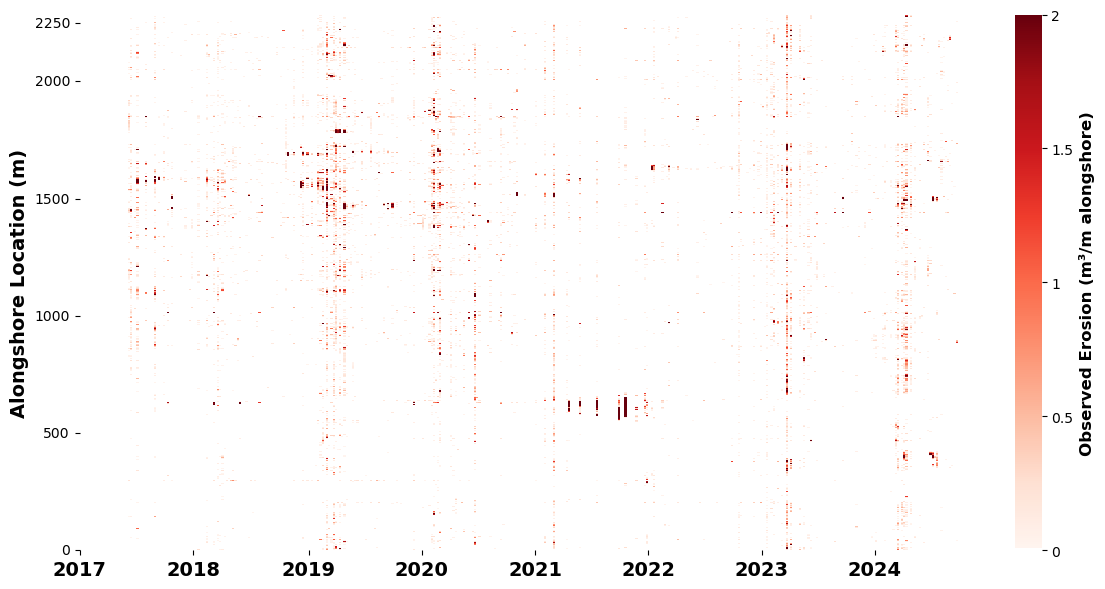

In [68]:
one_meter = plot_heatmap_grid_1m(cropped_grid, grid_files, 2, res=.01)

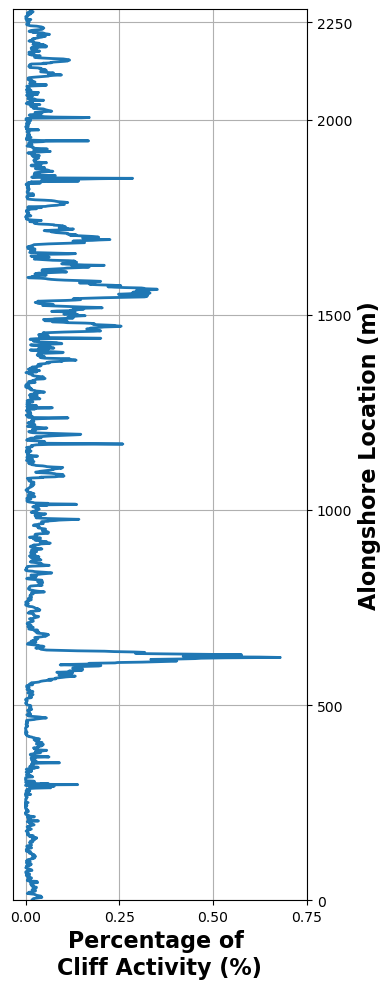

In [69]:
plot_fraction_alongshore(one_meter)

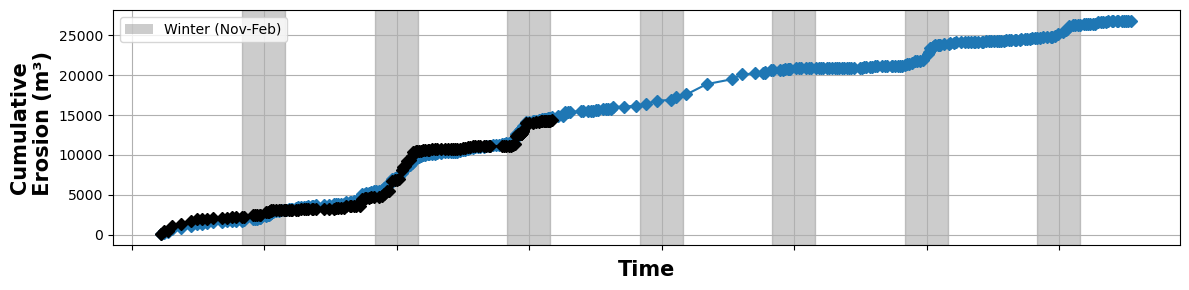

In [70]:
cum_erosion_curve(full_grid, grid_files, plotAdam=True, res=0.01)

In [ ]:
import os
import re

def check_subdirs_for_acc_files(base_path, required_count=2):
    """
    Checks each immediate subdirectory in base_path and returns a list of
    subdirectories that do NOT have exactly 'required_count' files with "acc" 
    in their names (case-insensitive). Only files directly inside each 
    subdirectory are considered.
    
    Parameters:
        base_path (str): The path containing subdirectories to check.
        required_count (int): The exact number of files with "acc" expected.
        
    Returns:
        list: A list of full paths for subdirectories that do not have exactly 
              'required_count' files containing "acc" in the name.
    """
    missing_subdirs = []
    
    # Compile a regex pattern for "acc" (case-insensitive)
    acc_pattern = re.compile("_acc_", re.IGNORECASE)
    
    # Iterate over each immediate entry in base_path
    for entry in os.listdir(base_path):
        subdir_path = os.path.join(base_path, entry)
        if os.path.isdir(subdir_path):
            # List immediate files only (not subdirectories)
            files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            # print(files)
            # Filter files that contain "acc" anywhere in the name
            acc_files = [f for f in files if acc_pattern.search(f)]
            if len(acc_files) != required_count:
                missing_subdirs.append(subdir_path)
    
    return missing_subdirs

if __name__ == '__main__':
    base_path = "/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output/delmar_grid_run_20240927"
    # Change required_count to 1 if you want exactly one file with "acc" per subdirectory.
    missing_subdirs = check_subdirs_for_acc_files(base_path, required_count=2)
    
    print("Number of subdirectories that do NOT have exactly two files with '_acc_' in the name:",
          len(missing_subdirs))
    for subdir in missing_subdirs:
        print(subdir)


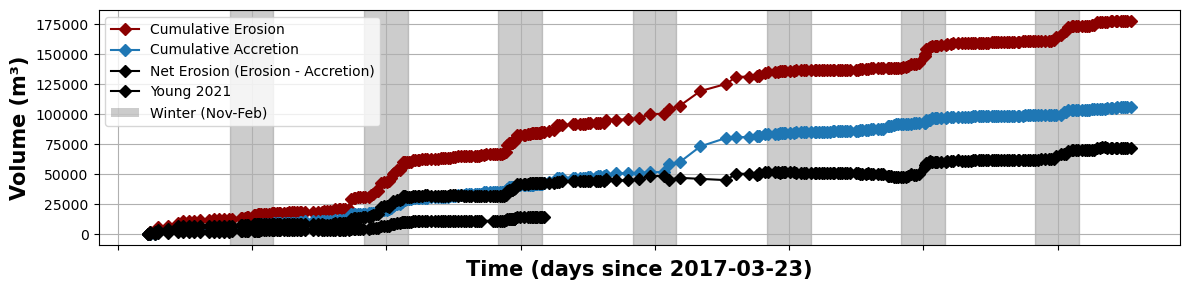

In [27]:
net_erosion_curve(cropped_grid, grid_files, acc_cropped_grid, acc_grid_files, plotAdam=True, res=0.1)

In [9]:
len(grid_files)

323

In [10]:
len(acc_grid_files)

304

In [25]:
one_meter = plot_heatmap_grid_1m(cropped_grid, cluster_files, 2, res=.01)

NameError: name 'plot_heatmap_grid_1m' is not defined

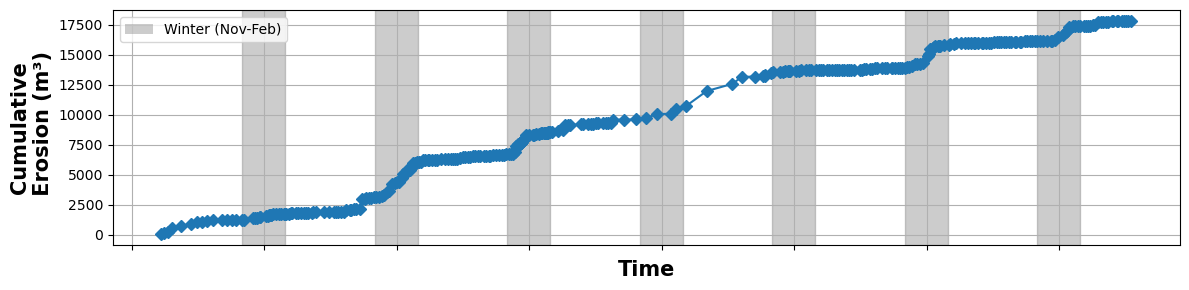

In [151]:
cum_erosion_curve(cropped_grid, cluster_files, plotAdam=False, res=.01)

In [31]:
plot_fraction_of_erosion(one_meter)


NameError: name 'plot_fraction_of_erosion' is not defined